# Packages


In [1]:
import numpy as np
import pandas as pd

from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

random_state = 10

# Import and understand dataset

In [2]:
df = pd.read_csv("datasets/Housing_dataset_train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


In [3]:
df.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.000000,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4862.700357,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,6.000000,5.000000,4.000000,2.586699e+06
max,12999.000000,9.000000,7.000000,6.000000,1.656849e+07


In [4]:
df.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [5]:
df.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

Removing data would result in the model working poorly because it dropped over 30% of the data after.<br/>
Hence, I decided to go with another way: <br/>
* using mean to replace null for columns with continuous data
* using U to replace null for columns with descrete data

In [6]:
# df.dropna(inplace=True)
# df.info()

df['bedroom'] = df['bedroom'].replace(np.nan, df['bedroom'].mean())
df['bathroom'] = df['bathroom'].replace(np.nan, df['bathroom'].mean())
df['parking_space'] = df['parking_space'].replace(np.nan, df['parking_space'].mean())
df['loc'] = df['loc'].replace(np.nan, 'U')
df['title'] = df['title'].replace(np.nan, 'U')

df = df.rename(columns={'loc': 'location'})
df.head()

,ID,location,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.000000,2.0,1.000000,1149999.565
1,2748,Ondo,Apartment,4.308171,2.0,4.000000,1672416.689
2,9261,Ekiti,U,7.000000,5.0,3.169825,3364799.814
3,2224,Anambra,Detached duplex,5.000000,2.0,4.000000,2410306.756
4,10300,Kogi,Terrace duplex,4.308171,5.0,6.000000,2600700.898


Split our data into feature X and target y and remove ID as it won't contribute anything meaningful to our model

In [28]:
X, y = df.iloc[:, 1:-1], df.iloc[:, -1]

# print(X.head())
# print(y.head())

## One-hot encoding the 2 columns that are categorical (location and title)

In [8]:
# df.describe()
# There are some categorical data in our dataset which we need to use one-hot encoding for as our model XGBRegressor
# can't work with it directly
print("Unique Locations:")
print(len(X['location'].unique()), X['location'].unique())
print("\n----------------------------\n")

print("Unique titles:")
print(len(X['title'].unique()), X['title'].unique())

Unique Locations:
37 ['Katsina' 'Ondo' 'Ekiti' 'Anambra' 'Kogi' 'Borno' 'Kwara' 'Osun' 'Kaduna'
 'Ogun' 'Bayelsa' 'U' 'Abia' 'Rivers' 'Taraba' 'Ebonyi' 'Kebbi' 'Enugu'
 'Edo' 'Nasarawa' 'Delta' 'Kano' 'Yobe' 'Benue' 'Bauchi' 'Cross River'
 'Niger' 'Adamawa' 'Plateau' 'Imo' 'Oyo' 'Zamfara' 'Sokoto' 'Jigawa'
 'Gombe' 'Akwa Ibom' 'Lagos']

----------------------------

Unique titles:
11 ['Semi-detached duplex' 'Apartment' 'U' 'Detached duplex' 'Terrace duplex'
 'Mansion' 'Bungalow' 'Penthouse' 'Townhouse' 'Flat' 'Cottage']


In [9]:
X = pd.get_dummies(X, columns=['location', 'title'])
X

,bedroom,bathroom,parking_space,location_Abia,location_Adamawa,location_Akwa Ibom,location_Anambra,location_Bauchi,location_Bayelsa,location_Benue,...,title_Bungalow,title_Cottage,title_Detached duplex,title_Flat,title_Mansion,title_Penthouse,title_Semi-detached duplex,title_Terrace duplex,title_Townhouse,title_U
0,2.000000,2.0,1.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,4.308171,2.0,4.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7.000000,5.0,3.169825,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5.000000,2.0,4.000000,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,4.308171,5.0,6.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,4.308171,7.0,3.169825,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
13996,4.308171,7.0,5.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13997,8.000000,6.0,5.000000,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
13998,4.308171,6.0,1.000000,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Split into training and test data

In [10]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [11]:
# print(train_X)
# print(train_y)
# print(test_X)
# print(test_y)

## Model Training and Tuning to get the best parameters
I did a gridsearch to test the combination of multiple parameters(parameter tuning) and found that the model performs best when n_estimators=1000 and max_depth=2

![Result of the grid search](images/grid_search.png "Result of the grid search")

In [12]:
# xgb_model = XGBRegressor(seed=random_state)

# clf = GridSearchCV(xgb_model, {
#     'max_depth': [2, 4, 6, 8],
#     'n_estimators': [50, 100, 200, 1000]}, verbose=1,
#     n_jobs=2
# )

xgb_model = XGBRegressor(
n_estimators=1000, max_depth=2, seed=random_state, n_jobs=2)

In [13]:
# clf.fit(train_X, train_y)

# print(clf.best_score_)
# print(clf.best_params_)

In [14]:
xgb_model.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=2, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Test our model with the test set to measure how well it performs
I used Mean absolute percentage error and Root Mean Square Error as the metrics

In [15]:
y_pred = xgb_model.predict(test_X)

In [16]:
# print(test_y[:100] - y_pred[:100])
print(y_pred[:50])
print(test_y[:50])

[1844901.   2054019.5   890165.4  3233336.5  1660812.9  1851561.1
 4227823.5  3130344.2  1394380.5  2598929.5  3171689.2  2021102.8
  682849.   2612116.2   916341.4  1199334.1  1252811.6  1987045.4
 1196701.1  1542867.2  1092092.5  3491377.2  2595759.2  1208197.8
 1526993.4  1089621.2  1164735.9  2217378.   2971721.   1553908.1
 1117376.9  2240569.   2378650.2   856014.5  2033740.5  1502003.2
 1224782.1   980382.94 2406968.   1072040.   2465189.2  1470591.4
 1263965.4  1177401.9  1522044.8  2977887.8  2019376.8  1335058.1
 1661785.   1633301.2 ]
5195     1.988463e+06
1236     2.162666e+06
13250    1.006986e+06
4225     3.115875e+06
9655     1.675506e+06
5523     1.802309e+06
10725    4.138085e+06
892      3.124382e+06
3787     1.856637e+06
6377     2.377560e+06
3000     3.080232e+06
5238     2.014705e+06
500      8.081459e+05
9553     1.634589e+06
4941     8.994005e+05
7749     1.309918e+06
13026    1.250452e+06
1900     2.045337e+06
5814     1.083756e+06
6941     1.582710e+06
1766    

In [17]:
rmse = np.sqrt(MSE(test_y, y_pred))

# Mean absolute percentage error
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [18]:
print("Root Mean Square Error is: ", rmse)
print("Mean absolute percentage error is : ", MAPE(test_y, y_pred))

Root Mean Square Error is:  555165.6422003998
Mean absolute percentage error is :  12.295603282802798


In [19]:
xgb_model.feature_importances_

array([0.08335333, 0.00773739, 0.00268932, 0.01517012, 0.00143098,
       0.04028882, 0.01890714, 0.01520766, 0.0489274 , 0.00230721,
       0.0123145 , 0.02699459, 0.03736947, 0.01534389, 0.01368368,
       0.00164893, 0.01562513, 0.00546372, 0.00546301, 0.01901557,
       0.00298798, 0.00189231, 0.00225751, 0.01747686, 0.00705366,
       0.00382101, 0.06303844, 0.00269299, 0.00176505, 0.03405701,
       0.01258546, 0.00218423, 0.01194941, 0.00072418, 0.05839191,
       0.01647827, 0.00170653, 0.00334415, 0.01696736, 0.01632722,
       0.04539895, 0.02421043, 0.02010624, 0.01859852, 0.02104631,
       0.13442634, 0.05146234, 0.00166633, 0.00080547, 0.00848156,
       0.00715408], dtype=float32)

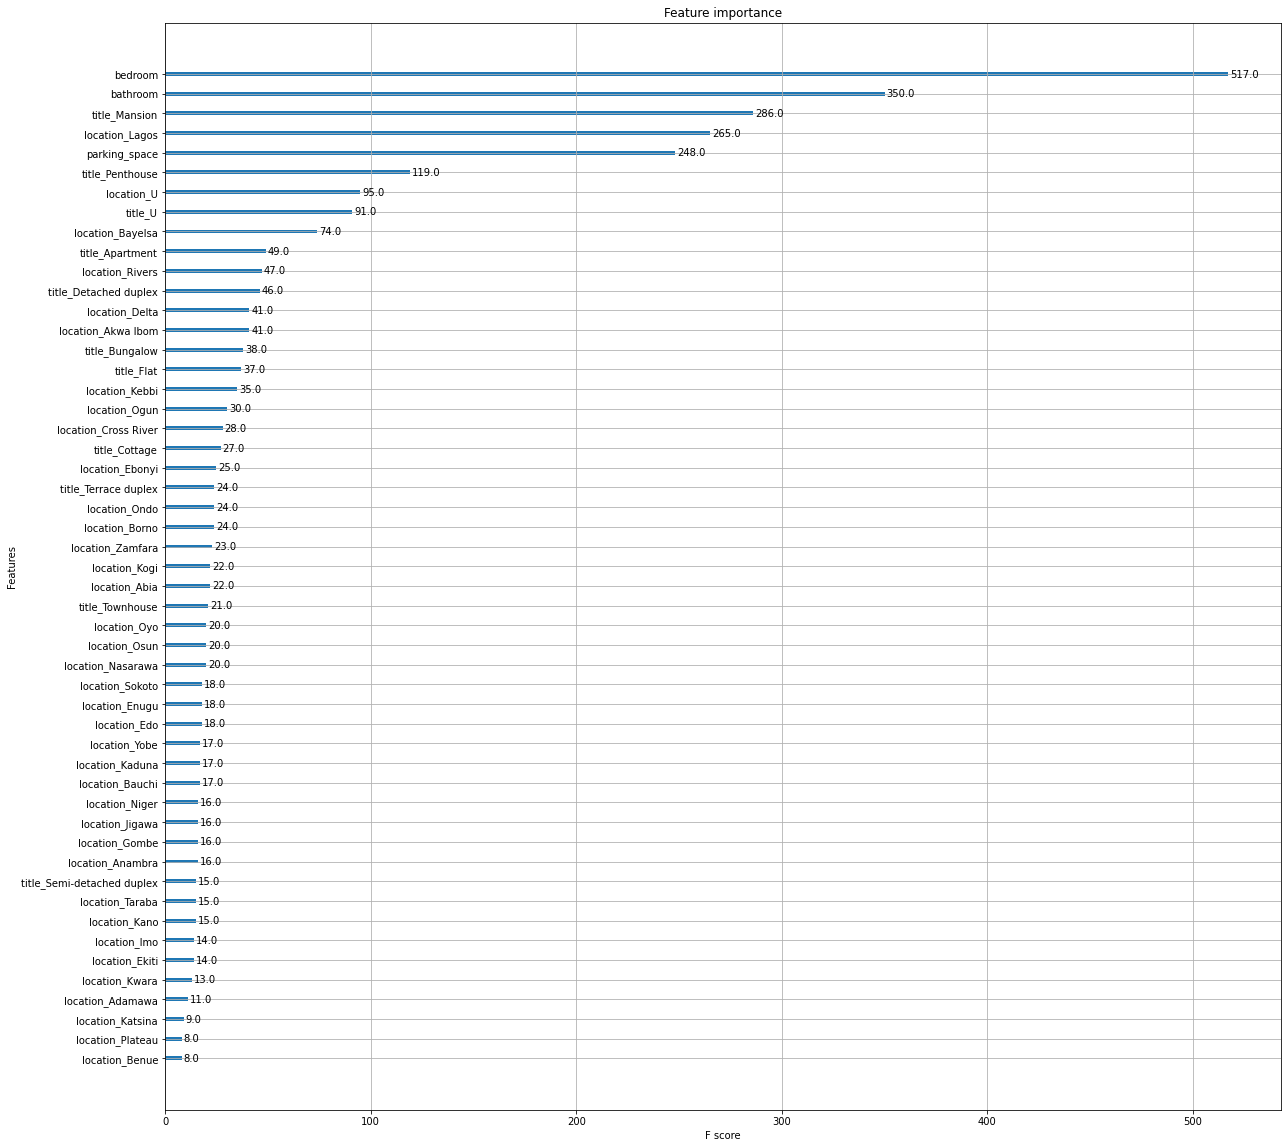

In [20]:
ax = plot_importance(xgb_model)

fig = ax.figure
fig.set_size_inches(20, 20)
ax.autoscale(enable=True) 

<br/><br/><br/>
# Using the model to make prediction on the new data

In [21]:
df_new = pd.read_csv("datasets/Housing_dataset_test.csv")
print(df.info())
print("\n First 5 data: \n")
print(df_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   location       14000 non-null  object 
 2   title          14000 non-null  object 
 3   bedroom        14000 non-null  float64
 4   bathroom       14000 non-null  float64
 5   parking_space  14000 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB
None

 First 5 data: 

      ID      loc                 title  bedroom  bathroom  parking_space
0    845     Kano             Penthouse        4         1              2
1   1924  Adamawa             Apartment        2         2              4
2  10718  Adamawa              Bungalow        2         7              2
3  12076    Lagos               Mansion        9         5              2
4  12254    Gombe  Semi-detached duplex

There are no null values in the new data we want to predict its prices so we can proceed without worrying about fixing null data

## Preparing the new data for  the model

In [22]:
df_new = df_new.rename(columns={'loc': 'location'})
X_new = df_new.iloc[:, 1:]

print(X_new)

     location                 title  bedroom  bathroom  parking_space
0        Kano             Penthouse        4         1              2
1     Adamawa             Apartment        2         2              4
2     Adamawa              Bungalow        2         7              2
3       Lagos               Mansion        9         5              2
4       Gombe  Semi-detached duplex        5         6              1
...       ...                   ...      ...       ...            ...
5995    Ekiti                  Flat        4         5              2
5996  Adamawa        Terrace duplex        5         7              1
5997      Oyo             Townhouse        4         1              4
5998   Bauchi                  Flat        3         7              5
5999   Sokoto               Mansion        6         1              6

[6000 rows x 5 columns]


In [23]:
X_new = pd.get_dummies(X_new, columns=['location', 'title'])
X_new = X_new.reindex(columns=X.columns.tolist(), fill_value=0)

# X_new['title_U'] = 0
# X_new['location_U'] = 0
X_new

,bedroom,bathroom,parking_space,location_Abia,location_Adamawa,location_Akwa Ibom,location_Anambra,location_Bauchi,location_Bayelsa,location_Benue,...,title_Bungalow,title_Cottage,title_Detached duplex,title_Flat,title_Mansion,title_Penthouse,title_Semi-detached duplex,title_Terrace duplex,title_Townhouse,title_U
0,4,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,2,4,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,7,2,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,9,5,2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,6,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,4,5,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5996,5,7,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5997,4,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5998,3,7,5,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [24]:
predictions = xgb_model.predict(X_new)
print(len(predictions))
print(len)
predictions

6000
<built-in function len>


array([2301447. , 1002975.3, 1212105.1, ..., 1877226.9, 1333527.8,
       3400643.5], dtype=float32)

## Export my results as a csv file

In [25]:
predictions_df = pd.DataFrame(predictions, index=df_new.index, columns=['Predicted House Price'])
df_with_predictions = pd.concat([df_new, predictions_df], axis=1)
print(df_with_predictions)

         ID location                 title  bedroom  bathroom  parking_space  \
0       845     Kano             Penthouse        4         1              2   
1      1924  Adamawa             Apartment        2         2              4   
2     10718  Adamawa              Bungalow        2         7              2   
3     12076    Lagos               Mansion        9         5              2   
4     12254    Gombe  Semi-detached duplex        5         6              1   
...     ...      ...                   ...      ...       ...            ...   
5995   1594    Ekiti                  Flat        4         5              2   
5996   2416  Adamawa        Terrace duplex        5         7              1   
5997  10195      Oyo             Townhouse        4         1              4   
5998   9455   Bauchi                  Flat        3         7              5   
5999  11736   Sokoto               Mansion        6         1              6   

      Predicted House Price  
0        

In [26]:
df_with_predictions.to_csv('datasets/Results_for_Housing_dataset_test.csv', encoding='utf-8', index=False)